# Online Chess Games - Exploration

Chess is a two-player strategy board game that has been around since the 6th century and played by millions worldwide.  Lichess.org is a major online chess server that is open-source.  In this notebook, I have performed an exploration on this [Dataset](https://www.kaggle.com/datasnaek/chess) of ~20,000 chess games from a selection* of users on the site Lichess.org.

*The selection criteria for the ~20,000 games: they were the most recent (as of Sept. 3rd, 2017, the dataset's creation) games taken from users of the top ~100 teams on Lichess.

As an amateur chess player, I have wondered if there are quantifiable differences between a low-rated chess game and a top-tier game.  There are plenty of possible factors to consider, but I have chosen a few factors worth investigating.  The basic outline follows:

**Contents**

[1. Dataset preparation](#1)
<br>[2. Overall Observations](#2)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Mean Rating](#2.1)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Victory Status](#2.2)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[2.3 White Advantage](#2.3)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[2.4 Length of Games](#2.4)
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.1 Number of Turns to Mate](#2.4.1)
<br>&nbsp;&nbsp;&nbsp;&nbsp;[2.5 Castling Preference](#2.5)
<br>[3. Conclusion](#3)

## <a id="1">1. Dataset Preparation</a>

As the first step, let us import the required libraries, load the dataset, check for missing data, remove duplicates, and create some additional features.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import ttest_ind
import re
from statistics import mode
%matplotlib inline

# Read csv file
games = pd.read_csv('games.csv') #both rated and unrated games

# Check if there are any missing data
print("Missing Data:  ", games.isnull().values.any())

# Inital Data Size Check
initial_size = games.shape[0]
print("Initial Size:  ", initial_size)

# Remove duplicates
games = games.drop_duplicates('id', 'first')

# Data Size Check
final_size = games.shape[0]
print("Duplicates: ".ljust(15), initial_size - final_size)
print("Final Size:  ".ljust(15), final_size)

Missing Data:   False
Initial Size:   20058
Duplicates:     945
Final Size:     19113


### Additional Features

These additional features will get used later on.

#### New Columns

In [2]:
# Adding another column calculating average of two player's ratings to get the game's rating
games['mean_rating'] = (games['white_rating'] + games['black_rating']) / 2

# New column for the difference in ratings
games['rating_difference'] = abs(games['white_rating'] - games['black_rating'])

#### Breaking into Brackets

In [3]:
# Breaking games up by brackets: below average, above average, top tier
under_1500 = games[games.mean_rating <= 1500]
under_2000 = games[(games.mean_rating < 2000) & (games.mean_rating > 1500)]
over_2000 = games[games.mean_rating >= 2000]

brackets = [under_1500, under_2000, over_2000]
bracket_titles = ['Under 1500', '1500-2000', 'Over 2000']

#### Common Functions to Output Common Graphs

In [100]:
# HISTOGRAM
# As I will be using this often...
# Defining a function that will create a histrogram with mean/std lines
# along with additional information underneath
def GamesHist(df, bins, color, column, xname, title):
    #Finding average and standard deviation of Column
    nd_mean = np.mean(df[column])
    nd_std = np.std(df[column])
    
    #Creating Histogram
    plt.figure(figsize=(15,5))

    plt.hist(df[column], bins=bins, color=color)
    plt.title(title)
    plt.xlabel(xname)
    plt.ylabel('Number of Games')
    plt.axvline(x=nd_mean, color = 'red')
    plt.axvline(x=nd_mean + nd_std, color = 'green')
    plt.axvline(x=nd_mean - nd_std, color = 'green')
    plt.show()
    
    #Printing additional info
    print( 'mode     '.ljust(8), mode(df[column]))
    print( df[column].describe())
    
# Pie Chart of Overall Data    
def OverallPie(column_of_interest):
    plt.figure(figsize=(5,5))
    plt.title('Overall')
    
    stats = games[column_of_interest].value_counts()
    plt.pie(stats, labels = stats.index, autopct='%.1f%%', shadow=True)
    plt.show()
    
# A Pie Chart for Each Bracket
def BracketPie(column_of_interest):
    plt.figure(figsize=(15,11))
    for i, bracket in enumerate(brackets):
        stats = bracket[column_of_interest].value_counts()
        plt.subplot(1, 3, i+1)
        plt.title(bracket_titles[i])
        plt.pie(stats, labels = stats.index, autopct='%.1f%%', shadow=True)

All players' rating starts at a tentative 1500 which increases or decreases based on game performance.  For further details on how Lichess calculates a player's rating, visit their [FAQ](https://lichess.org/faq#ratings).
+ **Below 1500** = Below Average
+ **1500-2000** = Above Average, but not top tier
+ **Above 2000** *(world champion sits around 2500)* = Top tier

## <a id="2">2. Overall Observations</a>

Again, we're wondering if we can find a difference between differently-rated games.  First, let's check the database for the size of each rating bracket.

In [107]:
games.head(5)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,mean_rating,rating_difference
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,1345.5,309
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,1291.5,61
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,1498.0,4
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,1446.5,15
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,1496.0,54


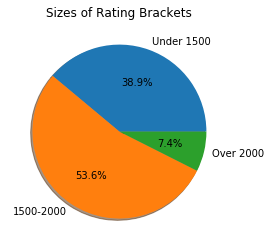

In [5]:
# Checking size of brackets
bracket_sizes = [under_1500.shape[0], under_2000.shape[0], over_2000.shape[0]]

plt.figure(figsize=(4,4))
plt.title('Sizes of Rating Brackets')
plt.pie(bracket_sizes, labels = bracket_titles, autopct='%.1f%%', shadow=True)
plt.show()

Right away, we can see over half the games covered are in the "above-average" bracket, while less than 10% of the games cover the "top-tier" bracket.  Let's check the overall rating distribution of the players.

### <a id="2.1">2.1 Mean Rating</a>

We can calculate the average rating of the game by taking the average of the two player's ratings.

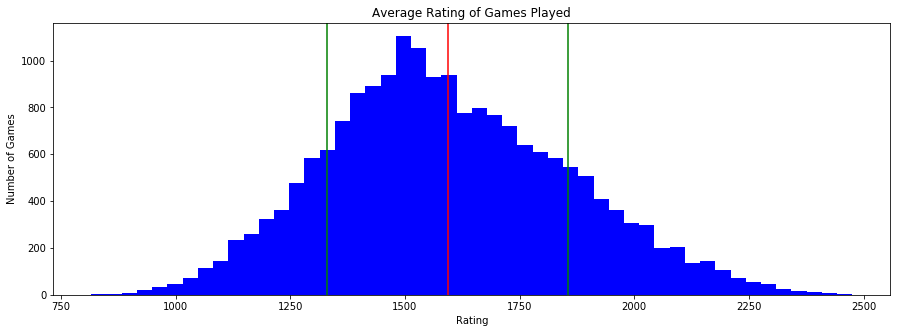

mode      1500.0
count    19113.000000
mean      1593.672762
std        262.541423
min        816.500000
25%       1409.500000
50%       1570.000000
75%       1772.500000
max       2475.500000
Name: mean_rating, dtype: float64


In [101]:
GamesHist(df=games, bins=50, color='blue', column='mean_rating', xname='Rating', title='Average Rating of Games Played')

That chart shows what the average rating is of the games in the database.  The mode of 1500 is not surprising as all players starting out has that rating, so that would be the most popular rating.  A normal-distribution is not a surprising shape for the histrogram.

### <a id="2.2">2.2 Victory Status</a>

There are four different ways for a game to end: 
+ getting checkmated *(mate)*, 
+ admitting defeat before getting checkmated *(resigning)* 
+ one side runs out of time *(out of time)*
+ neither side can win *(draw)*

Is there a difference between high/low rated players?

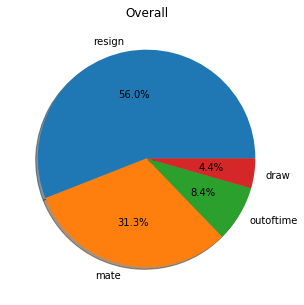

In [7]:
OverallPie('victory_status')

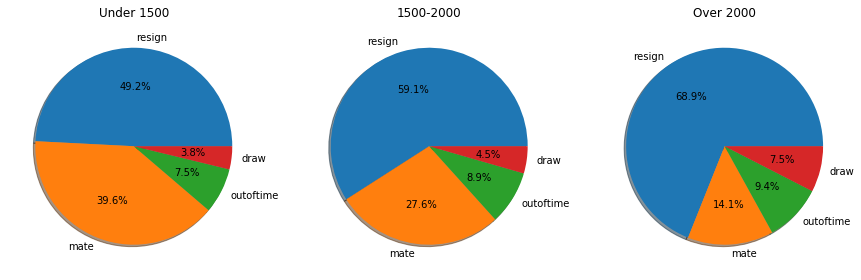

In [8]:
BracketPie('victory_status')

We see here that resignition is more likely the higher the rating.  A few possible reasons:
+ Players are more experienced and can recognize a lost position
+ Players at higher ratings trust their opponent will not blunder an opportunity to mate and resign ahead of time
+ Lower-rated players may not recognize a lost, winning, or even mating, position
+ Lower-rated players are more likely to blunder and lose their advantage

### <a id="2.3">2.3 White Advantage</a>

Whoever goes first in a turn-based game has an inherient advantage.  How much of an advantage do those playing white get?  Does it differ based on rating levels?

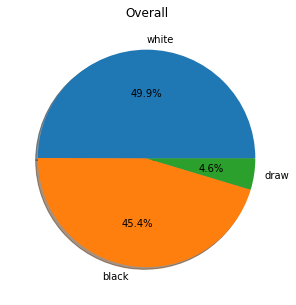

In [9]:
OverallPie('winner')

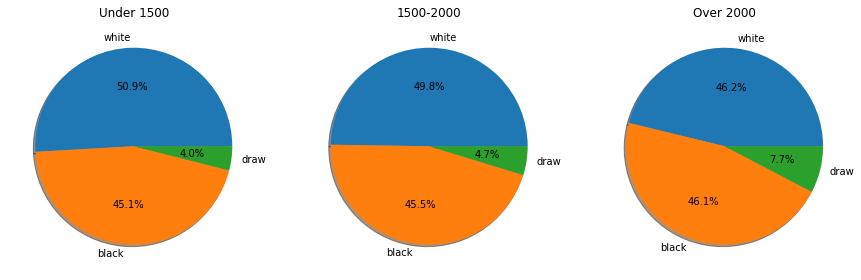

In [10]:
BracketPie('winner')

White does have a slight advantage, but it appears to even out the higher rated the games get.

There is a wikipedia article about [the advantage white has in chess](https://en.wikipedia.org/wiki/First-move_advantage_in_chess) by going first.  Further study should be done to examine the discrepancy.

### <a id="2.4">2.4 Length of Games</a>

How many moves are in a typical game, including all types of win conditions (mating, resigning, out-of-time, draw).

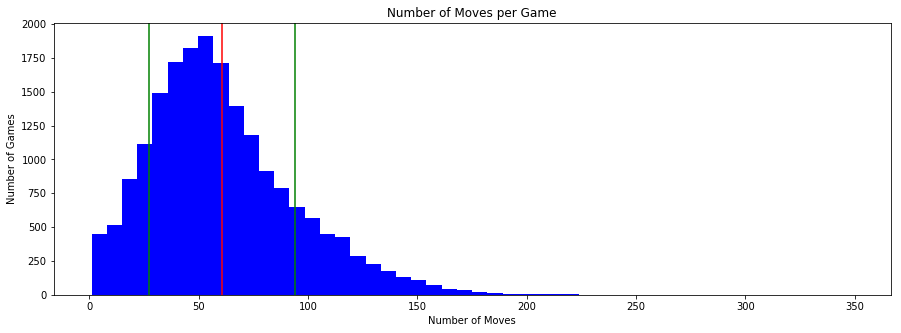

mode      45
count    19113.000000
mean        60.513839
std         33.488264
min          1.000000
25%         37.000000
50%         55.000000
75%         79.000000
max        349.000000
Name: turns, dtype: float64


In [102]:
GamesHist(games, 50, 'blue', column='turns', xname='Number of Moves', title='Number of Moves per Game')

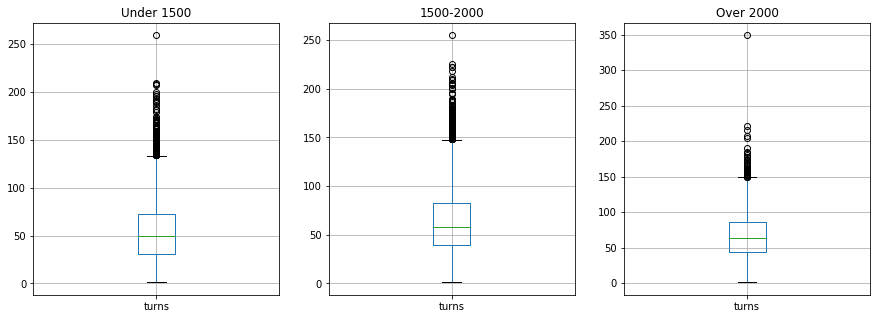

In [12]:
# Boxplot
plt.figure(figsize=(15,5))
for i, bracket in enumerate(brackets):
    plt.subplot(1, 3, i+1)
    plt.title(bracket_titles[i])
    bracket.boxplot(column=['turns'])

Although high-tier games tend to resign more (forfieting a game before being mated) the average moves for them are higher than low-tier games.  I wonder if only checking for games that end in mate will show differently.

#### <a id="2.4.1">2.4.1 Number of Turns to Mate</a>

What is the average number of moves that leads to mate?

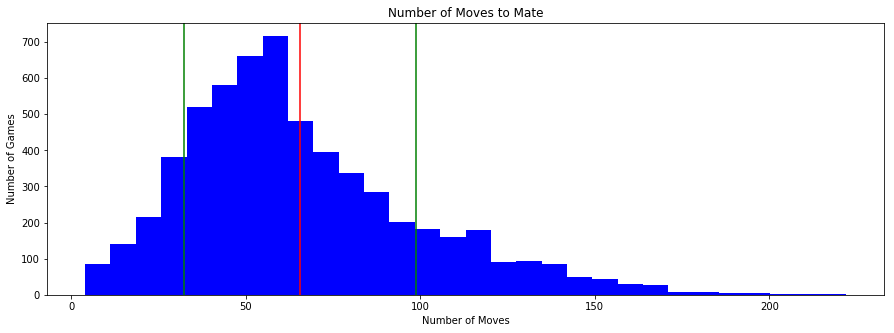

mode      52
count    5974.000000
mean       65.568966
std        33.166256
min         4.000000
25%        42.000000
50%        59.000000
75%        83.000000
max       222.000000
Name: turns, dtype: float64


In [106]:
# New DataFrame for only games that end in Mate
games_mate = games.loc[games['victory_status'] == 'mate']

GamesHist(games_mate, 30, 'blue', 'turns', 'Number of Moves', 'Number of Moves to Mate')

In [14]:
# Split previous DataFrame into rating Brackets
mate_under_1500 = under_1500[under_1500.victory_status=='mate']
mate_under_2000 = under_2000[under_2000.victory_status=='mate']
mate_over_2000 = over_2000[over_2000.victory_status=='mate']

m_brackets = [mate_under_1500, mate_under_2000, mate_over_2000]

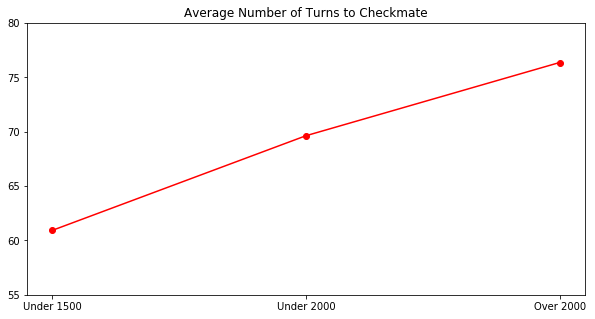

In [120]:
# Graph the average number of turns for each bracket/DataFrame
turn_means = [b.turns.mean() for b in m_brackets]

plt.figure(figsize=(10,5))
plt.ylim(55,80)
plt.title('Average Number of Turns to Checkmate')
plt.plot(bracket_titles, turn_means, 'o-', color='red')
plt.show()

It appears that on average, it takes more moves to end in mate the higher the rating goes.  It makes sense as higher-rated players are able to see mates and make better moves to prolong their life.

### <a id="2.5">2.5 Castling Preference</a>

Castling is a special move, the only move where you can move two pieces on the same turn.  It is a special move that puts your king into a safe position, away from the center of the action, and put it in a corner behind a row of pawns and a rook.

![title](img/castling.jpg)

+ The top image is an example of king-side castling.
+ The bottom image is an example of queen-side castling.

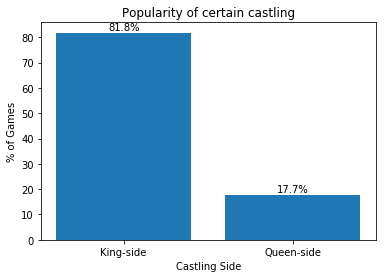

In [95]:
# New DataFrames with games that include certain castling
king_games = games.loc[games['moves'].str.contains('O-O ', flags=re.I, regex=True)]
queen_games = games.loc[games['moves'].str.contains('O-O-O', flags=re.I, regex=True)]

#Function for Castling Percentage
def CastlePercentage(df_castle, df_whole):
    return round(df_castle.shape[0] / df_whole.shape[0], 3) * 100

# Data to Plot
castling_games = ['King-side', 'Queen-side']
castling = [CastlePercentage(king_games, games), CastlePercentage(queen_games, games)]

#Attach a text label above each bar in *rects*, displaying its percentage.
def AutoLabel(rects): 
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 1 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Bar Plot
fig, ax = plt.subplots()
castling_bars = plt.bar(castling_games, castling)
AutoLabel(castling_bars)
plt.title('Popularity of certain castling')
plt.ylabel('% of Games')
plt.xlabel('Castling Side')
plt.show()

What I am checking are the percentage of games to showcase either side castling king/queen-side.  I chose to do a bar-graph rather than a pie-chart, as it is possible for games to have both king-side and queen-side castling, making the percentages not equal 100%.

In [87]:
# Split games with king-side castling by rating
king_under_1500 = king_games[king_games.mean_rating < 1500]
king_under_2000 = king_games[(king_games.mean_rating < 2000) & (king_games.mean_rating >= 1500)]
king_over_2000 = king_games[king_games.mean_rating > 2000]

# Split games with queen-side castling by rating
queen_under_1500 = queen_games[queen_games.mean_rating < 1500]
queen_under_2000 = queen_games[(queen_games.mean_rating < 2000) & (queen_games.mean_rating >= 1500)]
queen_over_2000 = queen_games[queen_games.mean_rating > 2000]

king_brackets = [king_under_1500, king_under_2000, king_over_2000]
queen_brackets = [queen_under_1500, queen_under_2000, queen_over_2000]
bracket_titles = ['Under 1500', 'Under 2000', 'Over 2000']

In [88]:
#Add Percentage into a list
def CastlePercentageList(castle_list, bracket_list):
    percentages = []
    for i in range(len(castle_list)):
        percentages.append(CastlePercentage(castle_list[i], bracket_list[i]))
    return percentages

king_brackets_percentages = CastlePercentageList(king_brackets, brackets)
queen_brackets_percentages = CastlePercentageList(queen_brackets, brackets)

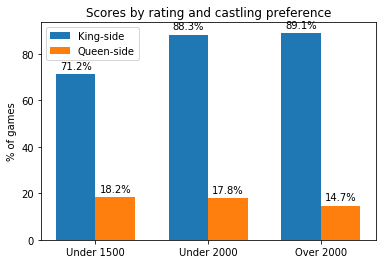

In [91]:
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, king_brackets_percentages, width, label='King-side')
rects2 = ax.bar(x + width/2, queen_brackets_percentages, width, label='Queen-side')

# Text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% of games')
ax.set_title('Scores by rating and castling preference')
ax.set_xticks(x)
ax.set_xticklabels(bracket_titles)
ax.legend()

AutoLabel(rects1)
AutoLabel(rects2)

plt.show()

As we can see, the higher-rated games castle more frequently, while castling queen-side slightly less frequently.  Possible reasons:
+ Not all low-level chess players may know of the special castling move
+ Castling is generally a good move, and doing so raises your rating

## <a id="3">3. Conclusion</a>

#### Summary:
+ Top tier games resign ~50% more than below-average rated games
+ Below-average games end sooner than top-tier games
+ Overall, there is a strong preference to castle king-side
+ Lower-rated games castle less

#### Flaws/Improvements for next time
+ Ideally should only compare players with known ratings
    + New players have a default rating of 1500
    + Should remove from database players that only play once
+ Mostly chess fanatics that join a website to play chess
+ Would love a bigger dataset to redo studies

What I should've changed:
+ Added df.head() to show the data that we were working with
+ Mod2 for even/odd moves to tell if it's white or black
+ Change graph scale
+ run QQ plot to see if it's certain type of distribution
+ run t-test
